### Covid-19 has caused devistating problems with the country's economy. You have been assigned to forecast the unemployment rate for next month (June 2020). Using a Recurrent Neural Network forecast one month into the future of what the Unemployment Rate will be for next month. 

### Make sure to back test your model against one or two previous months

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

### import Data
- Data was collected from the Federal Reserve Economic Data Website
- https://fred.stlouisfed.org/series/UNRATE
- Data begins Jan 1948 through march 2020 

In [2]:
data = pd.read_csv("resources/unemployment_rate.csv", parse_dates = True, index_col="DATE")

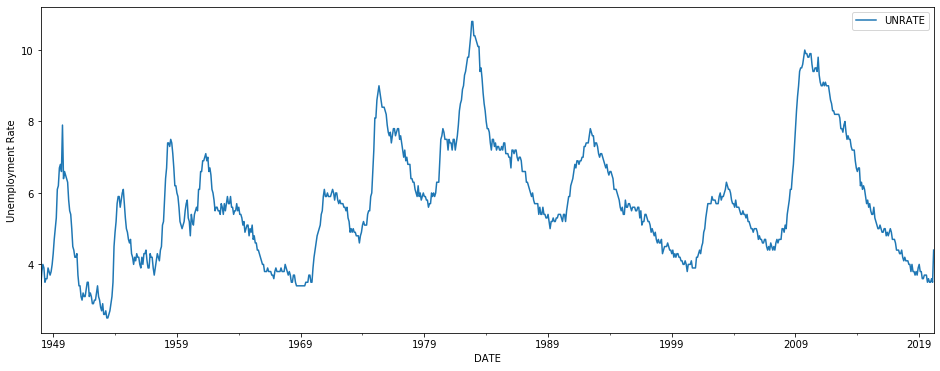

In [3]:
data.plot(figsize = (16,6))
plt.ylabel("Unemployment Rate");

### Data Sample
- We wil take 5 years of data to test
- This will be 60 months in total
- This will give us enough data to test out model on

In [4]:
sample_size = 60

In [5]:
sample_index = len(data) - sample_size

In [6]:
sample_index

807

In [7]:
len(data)

867

### Train Test Split

In [8]:
train = data.iloc[:sample_index]

In [9]:
test = data.iloc[sample_index:]

In [10]:
train.shape

(807, 1)

In [11]:
test.shape

(60, 1)

### Scaling the data
- This will allow our model to consider the outliers and the behavior of the data better

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scalar = MinMaxScaler()

In [14]:
train_scaled = scalar.fit_transform(train)

In [15]:
test_scaled = scalar.transform(train)

## Time Series Generator
- We will create the generator to train our model
- length will be 3 months- Our model will train to attampt to predict 3 months of Unemployment Rates

In [113]:
length = 2

In [114]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [115]:
gen = TimeseriesGenerator(train_scaled,train_scaled,length=length, batch_size=1)

### Early Stopping
- THis will allow our model to train and stop when beginning to overtrain 
- Also will allow us to set our epoch at a high value to train longer if possible

In [116]:
from tensorflow.keras.callbacks import EarlyStopping

In [117]:
stop = EarlyStopping(monitor="val_loss", mode = "min", patience=20)

### Validation Generator
- Allows them model to compare the training data to. We will use our testing set

In [118]:
val_gen = TimeseriesGenerator(test_scaled,test_scaled, length=length, batch_size=1)

## Creating Model
- We will use a LSTM model to prevent gradient decay of our network

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [120]:
n_features = 1

In [121]:
model = Sequential()
model.add(LSTM(units = 250, activation = "relu", input_shape = (length,n_features)))
model.add(Dense(units = 1))
model.compile(optimizer = "adam", loss = "mse")

### Fitting Model
- We will add all of our created parameters to to boost efficiency in training

In [122]:
model.fit_generator(generator=gen, validation_data=val_gen, epochs=40, callbacks=[stop])

Epoch 1/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0100 - val_loss: 0.0012
Epoch 2/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0012 - val_loss: 9.0027e-04
Epoch 7/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0013 - val_loss: 9.9298e-04
Epoch 8/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0010 - val_loss: 7.7924e-04
Epoch 9/40
805/805 [==============================] - 21s 26ms/step - loss: 0.0010 - val_loss: 8.1457e-04
Epoch 10/40
805/805 [==============================] - 21s 26ms/st

### Model Performance
- Lets take a look at how our model did training
- appears that our model trained very well and did not overtrain at the end
- We will test the the model by making soe predicitons

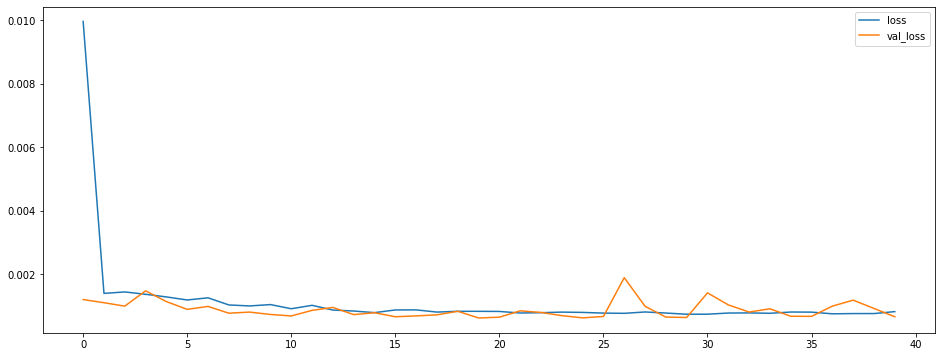

In [123]:
pd.DataFrame(model.history.history).plot(figsize = (16,6))

## Predicitons
- We will test our model on predicting the test data before forecasting
- This will give us a better understanding of the model accuracy

In [124]:
test_predictions = []
batch = train_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))
for x in range(len(test)):
    current_predictions = model.predict(current_batch)[0]
    test_predictions.append(current_predictions)
    current_batch = np.append(current_batch[:,1:,:], [[current_predictions]], axis = 1)  

### inverse predicitons
 - our model was trained on scaled data so we must inverse that process to get the true values

In [125]:
true_predicitons = scalar.inverse_transform(test_predictions)

## Matching True and Test

In [126]:
test["predictions"] = true_predicitons

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Plotting Test and Predictions
- Using the LSTM model the predicitons are mostly accurate for the first value forward. We will consider this for our forecast and take a close look at the first month forward.
- model prediciton on 2015 was 5.28 and the true value was 5.4. This was pretty close in prediction
- We will run our forecast below

In [127]:
test.head()

,UNRATE,predictions
DATE,,
2015-04-01,5.4,5.435588
2015-05-01,5.6,5.487394
2015-06-01,5.3,5.540391
2015-07-01,5.2,5.592756
2015-08-01,5.1,5.644289


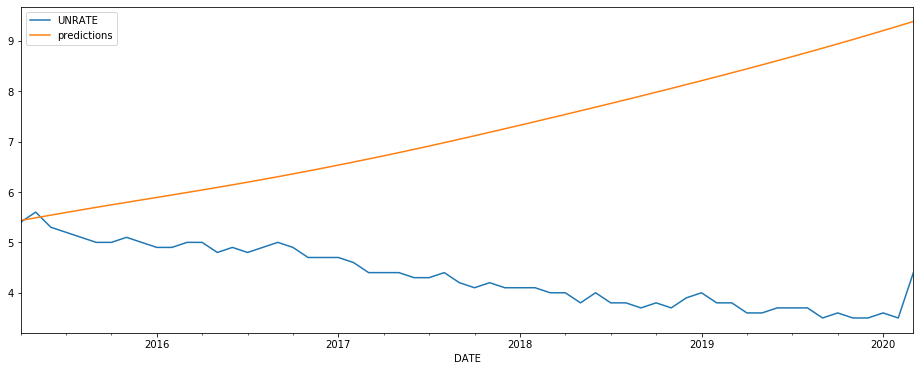

In [128]:
test.plot(figsize = (16,6))

## Forecasting with model
- Our forecast will be to predict the next month of May 2020

In [129]:
forecast  = []
periods = length
first_batch = train_scaled[-length:]
c_batch = first_batch.reshape((1,length,n_features))
for x in range(periods):
    pre = model.predict(c_batch)[0]
    forecast.append(pre)
    c_batch = np.append(c_batch[:,1:,:], [[pre]], axis=1)

## Inverse Forecast

In [130]:
true_forecast = scalar.inverse_transform(forecast)

In [131]:
true_forecast

array([[5.43558815],
       [5.48739359]])

## Time Series creation for forecast
- must begin at the end of the data at month's start
- last day in data shown below

In [132]:
data.tail()[-1:]

,UNRATE
DATE,
2020-03-01,4.4


In [133]:
time_index = pd.date_range(start="2020-4-1", periods=periods, freq="MS")

In [134]:
time_index

DatetimeIndex(['2020-04-01', '2020-05-01'], dtype='datetime64[ns]', freq='MS')

In [135]:
forecast_data_frame = pd.DataFrame(true_forecast, index=time_index, columns=["forecast"])

## Model Predicts the unemployment rate for 4/2020 will be 5.28
- we will plot this on a graph below

In [136]:
forecast_data_frame

,forecast
2020-04-01,5.435588
2020-05-01,5.487394


(599, 605)

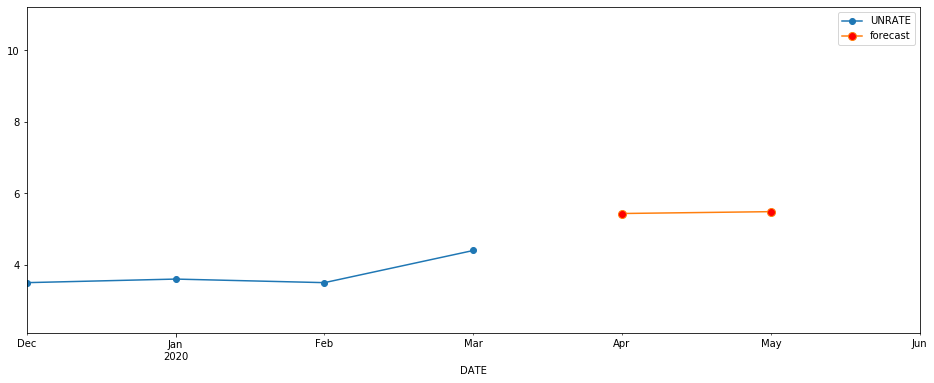

In [137]:
ax = data.plot(figsize = (16,6), marker = 'o')
forecast_data_frame.plot(ax = ax, marker = "o", mfc = "r", ms = 8)
plt.xlim("2019-12-30","2020-6-1")

### Saving Model 

In [151]:
model.save("unemployment_Model.h5")

### Back testing the model
- We will take the data up to year end 2018 and forecast for jan 1 2019
- THis will allow us to see how our model performed

In [139]:
new_data = data.loc["1948-01-01": "2018-12-1"]

In [140]:
new_scalar = MinMaxScaler()

In [141]:
new_data_scaled = new_scalar.fit_transform(new_data)

### Forecast and back testing

In [142]:
forecast = []
period = length
b = new_data_scaled[-length:]
curr_batch = b.reshape((1,length,n_features))
for x in range(period):
    predd = model.predict(curr_batch)[0]
    forecast.append(predd)
    curr_batch = np.append(curr_batch[:,1:,:], [[predd]], axis=1)

In [143]:
t_forecast = new_scalar.inverse_transform(forecast)

In [144]:
t_forecast

array([[3.98228661],
       [4.04095157]])

In [145]:
new_data.tail()[-1:]

,UNRATE
DATE,
2018-12-01,3.9


In [146]:
t_index = pd.date_range(start="2019-1-1", periods=period, freq='MS')

In [147]:
t_index

DatetimeIndex(['2019-01-01', '2019-02-01'], dtype='datetime64[ns]', freq='MS')

In [148]:
fotecast_Df =pd.DataFrame(t_forecast,index=t_index, columns=["forecast"])

### Model Predicts 3.98 
- True value was 4.0
- Model is very Accurate in predictions of unemployment rate

In [149]:
fotecast_Df

,forecast
2019-01-01,3.982287
2019-02-01,4.040952


In [150]:
data.loc["2019-1-1"]

UNRATE    4.0
Name: 2019-01-01 00:00:00, dtype: float64